### Clustering of words based on UMAP and sbert
[sbert](https://www.sbert.net/)
[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [1]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [101]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile1)) as json_file:
    defWord1 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile2)) as json_file:
    defWord2 = json.load(json_file)

with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/in/' + str(defFile3)) as json_file:
    defWord3 = json.load(json_file)


defWord = defWord1 + defWord2 + defWord3

print(len(defWord))

552


### Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [102]:
# remove duplicates
defSing = [word for word in list(set(defWord)) if type(word) is str]

print(len(defSing))

327


In [103]:
from sentence_transformers import SentenceTransformer

# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2') # SentenceTransformer('all-mpnet-base-v2')
sentence_embeddings = model.encode(defSing)
print(sentence_embeddings.shape)

(327, 768)


### Clustering
We now follow the guide of topic modelling, [guide](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)

In [110]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

dataset = sentence_embeddings

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(dataset)

print(len(dataset))

327


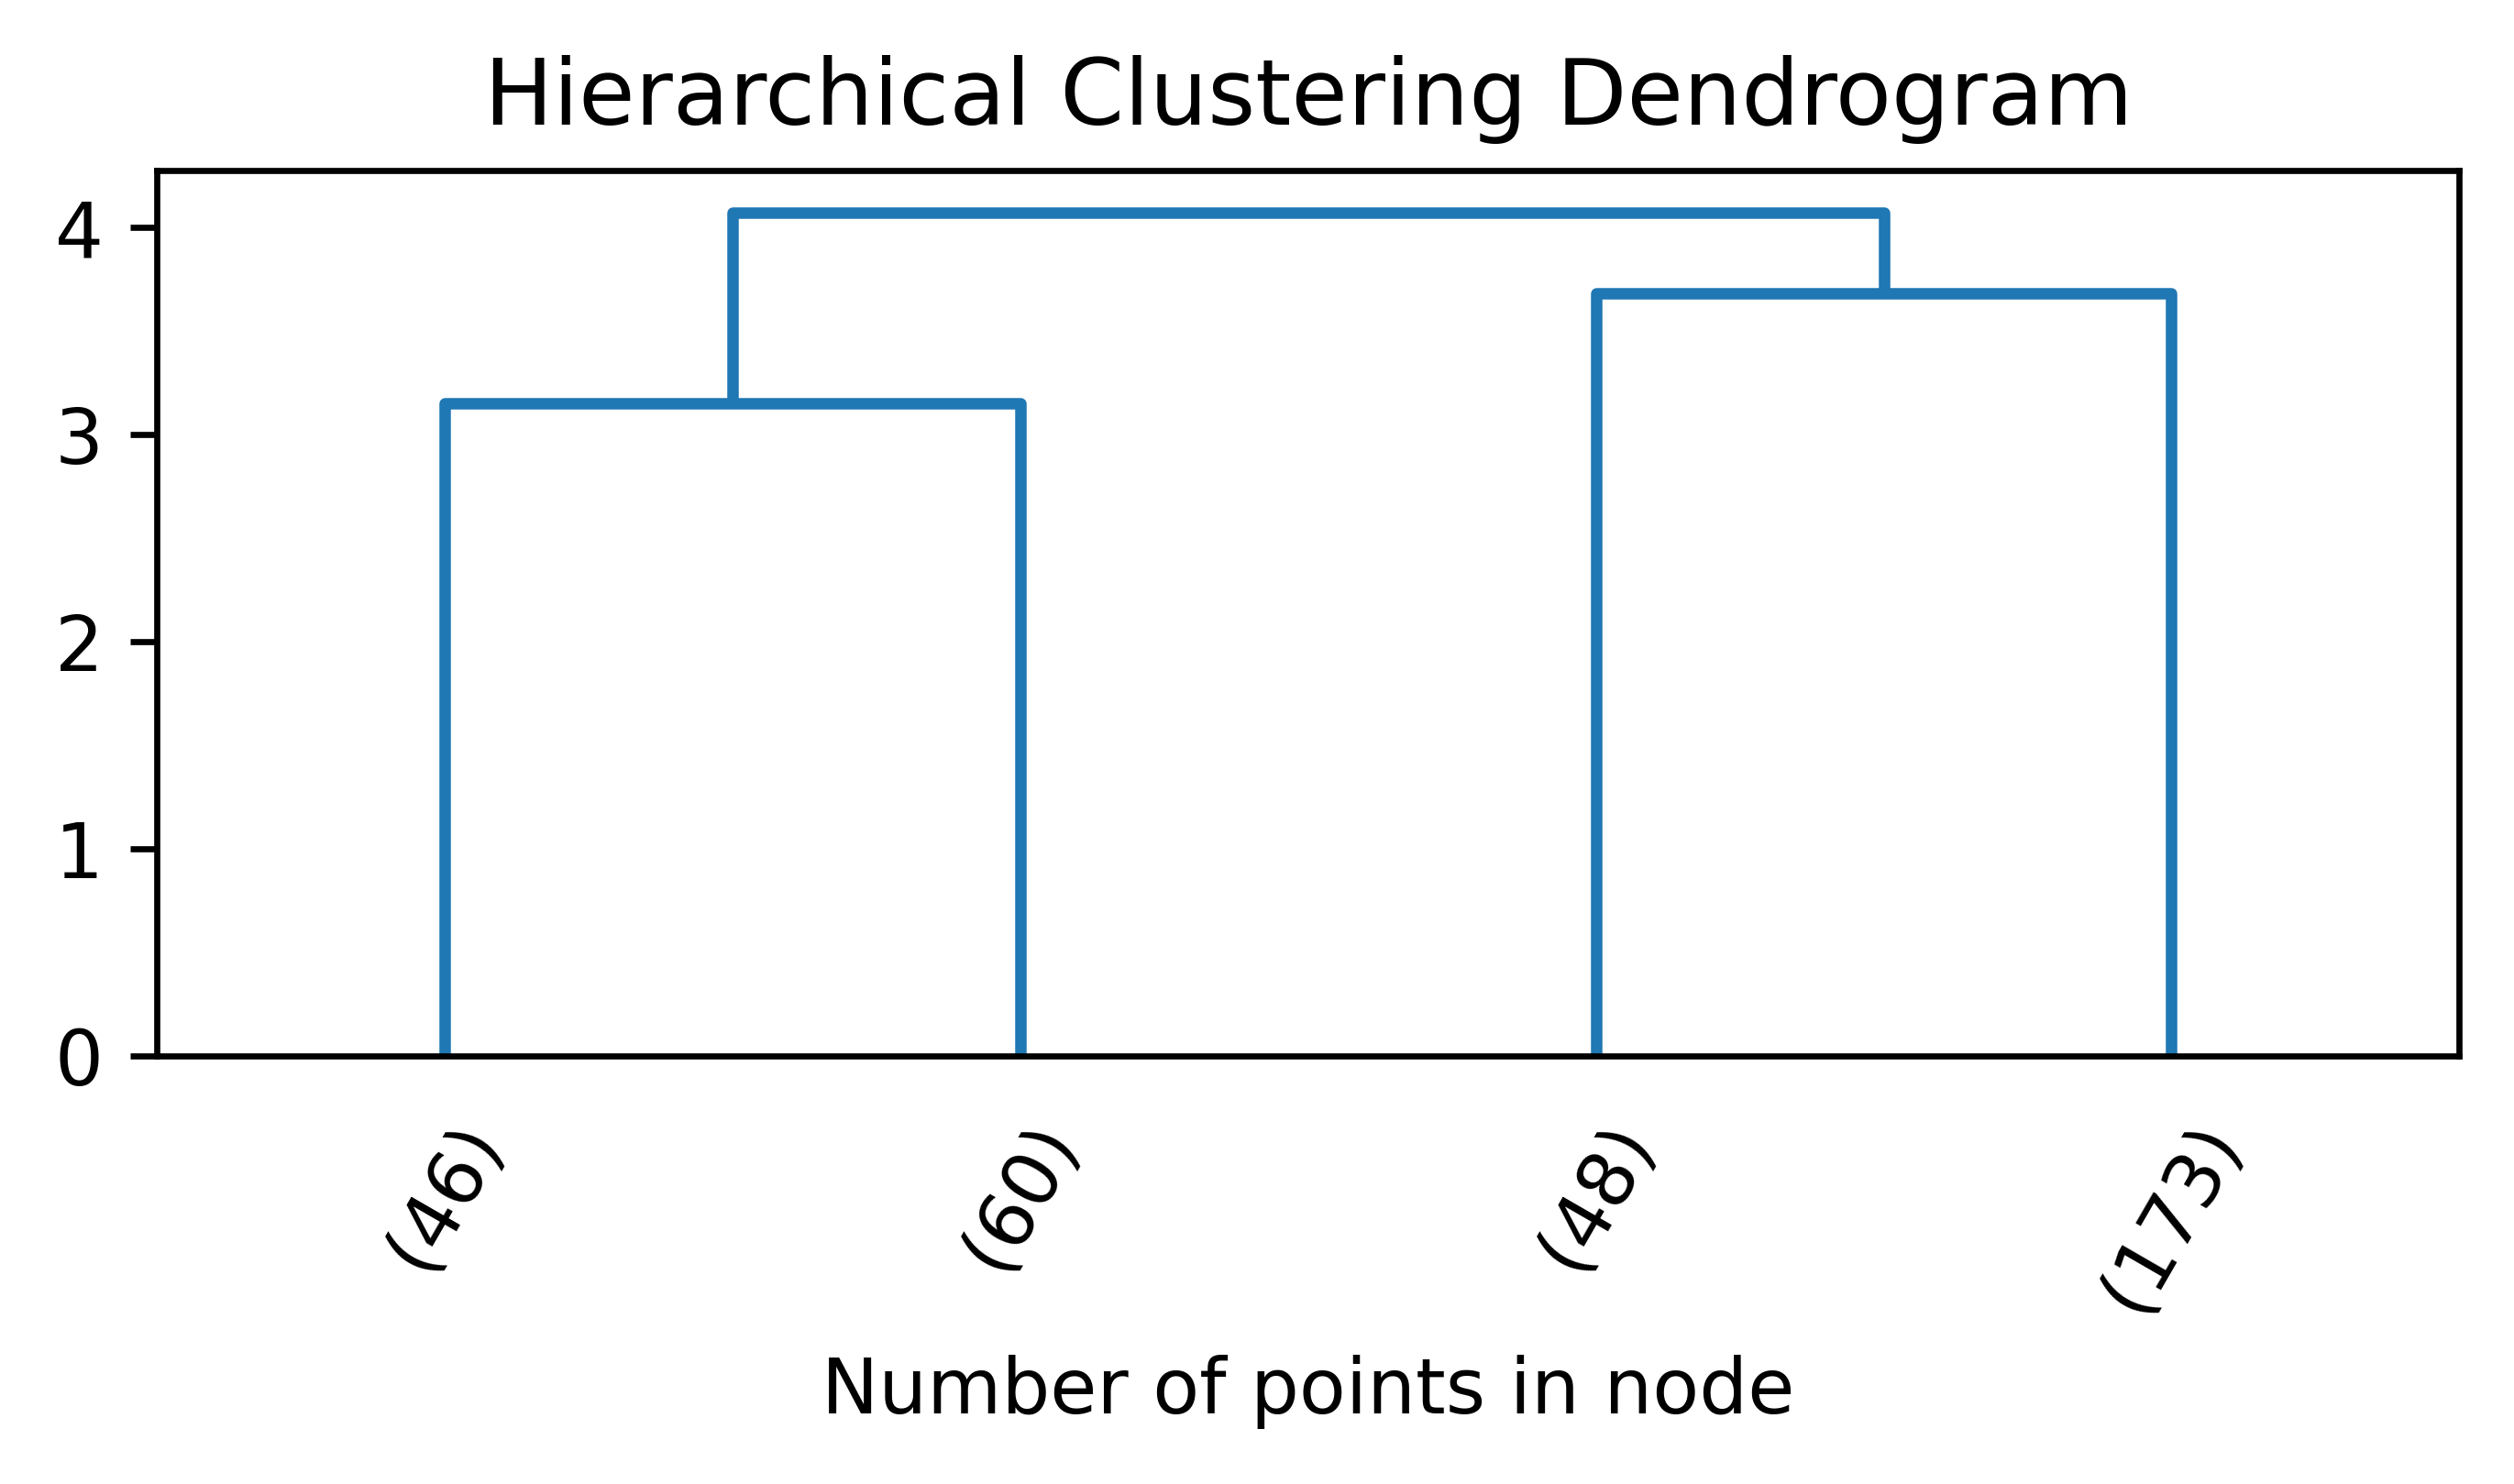

In [111]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendo = dendrogram(linkage_matrix, **kwargs)

    return linkage_matrix, dendo

plt.figure(figsize=(3240/600, 1280/600), dpi=600)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram

# 8 with push-force
p = 4
linkageMatrix, dendoPlot = plot_dendrogram(model, truncate_mode="lastp", p=p, leaf_rotation=60.,leaf_font_size=10.)
#linkageMatrix, dendoPlot = plot_dendrogram(model, leaf_rotation=60.,leaf_font_size=3.)
plt.xlabel("Number of points in node")
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/denogrammClusteringRaw.png', dpi=600, bbox_inches = 'tight')
plt.savefig('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.svg', dpi=600, bbox_inches = 'tight')
#print(dendoPlot["leaves"])

label = fcluster(linkageMatrix, p, criterion='maxclust')

#print(label)

d = {'primitive': defSing, 'label':label}
#print(d)

hierarchies = pd.DataFrame(d)

#print(hierarchies)


As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [112]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# group by "X" column
groups = hierarchies.groupby('label')

labels = []
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    groups.get_group(i)

    n_gram_range = (1, 1)
    stop_words = "english"

    # Extract candidate words/phrases
    count = CountVectorizer(ngram_range=n_gram_range, stop_words = stop_words).fit(groups.get_group(i)['primitive'])
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2')
    doc_embedding = model.encode(groups.get_group(i)['primitive'].to_list())
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
    print("GROUP: " + str(i))
    print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    print(matchedKeywords)


    
    labels.append(matchedKeywords)

    # put keywords on the hierechical clustering

print(labels)

GROUP: 1
['synchronization', 'synchronize']
synchronization-synchronize
GROUP: 2
['dynamic', 'movemement']
dynamic-movemement
GROUP: 3
['grab', 'grasp']
grab-grasp
GROUP: 4
['screwdriving', 'screw']
screwdriving-screw
['synchronization-synchronize', 'dynamic-movemement', 'grab-grasp', 'screwdriving-screw']
